In [1]:
import os
import torch
from trainer import Trainer

from Preprocessing import (
    filter_collate_fn,
    generate_file_path,
    get_train_transform,
    get_validation_transform
)

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    SmartCacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

from monai.losses import DiceCELoss

from monai.networks.nets import SwinUNETR
from map_to_binary import class_map_5_parts
from monai.data.utils import pad_list_data_collate


MONAI version: 1.2.dev2313
Numpy version: 1.23.5
Pytorch version: 2.0.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 331437dfce075b4fa5785016ad4e7f8c7c77ad21
MONAI __file__: D:\Arash\Semester2\DeepLearning\FinalProject\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.0
gdown version: 4.7.1
TorchVision version: 0.15.1+cu118
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.3
einops version: 0.6.0
transformers version: 4.27.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
task_name = 'cardiac'
val_transforms = get_validation_transform()
train_transforms = get_train_transform(num_samples=4)

# Load Dataset

In [3]:
root_dataset = 'DatasetCombined'
label_name = f'labels_task_{task_name}'

In [4]:
file_list_val = generate_file_path(root_path=f'{root_dataset}/val', label_name=label_name)
file_list_train = generate_file_path(root_path=f'{root_dataset}/train', label_name=label_name)

KeyboardInterrupt: 

In [4]:
train_ds = PersistentDataset(
    data=file_list_train,
    transform=train_transforms,
    cache_dir=f'C:/Training/train_{task_name}'
)

train_loader = ThreadDataLoader(train_ds, batch_size=1, shuffle=True,
                                collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96))
                               )

In [5]:
val_ds = PersistentDataset(
    data=file_list_val,
    transform=val_transforms,
    cache_dir=f'val_{task_name}'
#     cache_dir='C:/Training/val'
)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=0,
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [4]:
num_of_classes = len(class_map_5_parts[f'class_map_part_{task_name}']) + 1
num_of_classes

17

# Model

In [5]:
root_dir = 'Model'
model_folder = os.path.join(root_dir, f'SwinTransformer_{task_name}')
if not os.path.isdir(model_folder):
    os.makedirs(model_folder)

In [6]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=num_of_classes,
    feature_size=48,
#     drop_rate=0.25,
    use_checkpoint=True,
)

In [7]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1, lambda_ce=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [8]:
swin_trainer = Trainer(
    model=model,
    max_epoch=1000,
    optimizer=optimizer,
    num_samples=4,
    loss_function=loss_function,
    model_root_path=model_folder,
    number_of_classes=num_of_classes,
    )
swin_trainer.load_weights()

In [11]:
torch.backends.cudnn.benchmark = True
swin_trainer.train(train_loader, val_loader)

Validate (loss=1.05429): 100%|█████████████████████████████████████████████████████████| 55/55 [02:53<00:00,  3.16s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.15296822786331177 Current Avg. Dice: 0.15296822786331177


Validate (loss=0.84996): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.3727213740348816 Current Avg. Dice: 0.3727213740348816


Validate (loss=0.72742): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5075340270996094 Current Avg. Dice: 0.5075340270996094


Validate (loss=0.64317): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5833728909492493 Current Avg. Dice: 0.5833728909492493


Validate (loss=0.59170): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6231897473335266 Current Avg. Dice: 0.6231897473335266


Validate (loss=0.54724): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6625035405158997 Current Avg. Dice: 0.6625035405158997


Validate (loss=0.53293): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6971206665039062 Current Avg. Dice: 0.6971206665039062


Validate (loss=0.49634): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7428083419799805 Current Avg. Dice: 0.7428083419799805


Validate (loss=0.50324): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7428083419799805 Current Avg. Dice: 0.7407244443893433


Validate (loss=0.49198): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7486154437065125 Current Avg. Dice: 0.7486154437065125


Validate (loss=0.46171): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.01s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7671636939048767 Current Avg. Dice: 0.7671636939048767


Validate (loss=0.46919): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7722275257110596 Current Avg. Dice: 0.7722275257110596


Validate (loss=0.45205): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7741583585739136 Current Avg. Dice: 0.7741583585739136


Validate (loss=0.43442): 100%|█████████████████████████████████████████████████████████| 55/55 [02:42<00:00,  2.96s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7965880036354065 Current Avg. Dice: 0.7965880036354065


Validate (loss=0.42715): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 1, best loss: 0.49766247841444883, current_loss: 0.4973642807115208
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7993398308753967 Current Avg. Dice: 0.7993398308753967


Validate (loss=0.42631): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 2, best loss: 0.49766247841444883, current_loss: 0.49681804911656813
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.7993398308753967 Current Avg. Dice: 0.7952784895896912


Validate (loss=0.41766): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.96s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8092374801635742 Current Avg. Dice: 0.8092374801635742


Validate (loss=0.43554): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.4861612525853244, current_loss: 0.4881108666008169
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8092374801635742 Current Avg. Dice: 0.8035899996757507


Validate (loss=0.43033): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 2, best loss: 0.4861612525853244, current_loss: 0.4890425235033035
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8092374801635742 Current Avg. Dice: 0.7996776103973389


Validate (loss=0.41586): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8228093981742859 Current Avg. Dice: 0.8228093981742859


Validate (loss=0.42212): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 1, best loss: 0.474648562615568, current_loss: 0.48296424096280877
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8228093981742859 Current Avg. Dice: 0.8072562217712402


Validate (loss=0.41891): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.01s/it]


Early Stopping patience: 2, best loss: 0.474648562615568, current_loss: 0.47415215129202065
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8228093981742859 Current Avg. Dice: 0.8190710544586182


Validate (loss=0.40585): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  3.00s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8228093981742859 Current Avg. Dice: 0.82123863697052


Validate (loss=0.42183): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8274716734886169 Current Avg. Dice: 0.8274716734886169


Validate (loss=0.41313): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.46816985512321646, current_loss: 0.4675943913784894
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8274716734886169 Current Avg. Dice: 0.8205151557922363


Validate (loss=0.40270): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8299735188484192 Current Avg. Dice: 0.8299735188484192


Validate (loss=0.40418): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.46407961777665396, current_loss: 0.4649651032957164
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8299735188484192 Current Avg. Dice: 0.8251155614852905


Validate (loss=0.40577): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8376989364624023 Current Avg. Dice: 0.8376989364624023


Validate (loss=0.40919): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.45742335400798106, current_loss: 0.4582262999632142
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8380894064903259 Current Avg. Dice: 0.8380894064903259


Validate (loss=0.40023): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 2, best loss: 0.45742335400798106, current_loss: 0.4619780414483764
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8380894064903259 Current Avg. Dice: 0.8380831480026245


Validate (loss=0.40328): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8380894064903259 Current Avg. Dice: 0.8376787900924683


Validate (loss=0.39858): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.45555431802164426, current_loss: 0.45713027065450496
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8380894064903259 Current Avg. Dice: 0.8357685208320618


Validate (loss=0.39417): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8398483991622925 Current Avg. Dice: 0.8398483991622925


Validate (loss=0.39700): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 1, best loss: 0.4533586552197283, current_loss: 0.45396692834117197
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8398483991622925 Current Avg. Dice: 0.8372632265090942


Validate (loss=0.39554): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.01s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8441547751426697 Current Avg. Dice: 0.8441547751426697


Validate (loss=0.39937): 100%|█████████████████████████████████████████████████████████| 55/55 [02:46<00:00,  3.03s/it]


Early Stopping patience: 1, best loss: 0.4477178619666533, current_loss: 0.45574115826324985
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8441547751426697 Current Avg. Dice: 0.8355910778045654


Validate (loss=0.38600): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 2, best loss: 0.4477178619666533, current_loss: 0.44757036620920354
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8482221961021423 Current Avg. Dice: 0.8482221961021423


Validate (loss=0.39701): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 3, best loss: 0.4477178619666533, current_loss: 0.44768483394926245
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8491175770759583 Current Avg. Dice: 0.8491175770759583


Validate (loss=0.39086): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.853600800037384 Current Avg. Dice: 0.853600800037384


Validate (loss=0.39408): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8539389371871948 Current Avg. Dice: 0.8539389371871948


Validate (loss=0.38754): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.44126919494433836, current_loss: 0.44041971496560356
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8539389371871948 Current Avg. Dice: 0.8509385585784912


Validate (loss=0.38603): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 2, best loss: 0.44126919494433836, current_loss: 0.4418094672939994
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8539389371871948 Current Avg. Dice: 0.8453568816184998


Validate (loss=0.38930): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 3, best loss: 0.44126919494433836, current_loss: 0.4424372904679992
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8539389371871948 Current Avg. Dice: 0.8518849015235901


Validate (loss=0.39783): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 4, best loss: 0.44126919494433836, current_loss: 0.4454359408129345
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8539389371871948 Current Avg. Dice: 0.8531455993652344


Validate (loss=0.38942): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8541989326477051 Current Avg. Dice: 0.8541989326477051


Validate (loss=0.38513): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 1, best loss: 0.4380179579962384, current_loss: 0.4379426846450025
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8558337688446045 Current Avg. Dice: 0.8558337688446045


Validate (loss=0.38576): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 2, best loss: 0.4380179579962384, current_loss: 0.4397539347410202
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8558337688446045 Current Avg. Dice: 0.8533521890640259


Validate (loss=0.39328): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 3, best loss: 0.4380179579962384, current_loss: 0.4414014063098214
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8558337688446045 Current Avg. Dice: 0.848105251789093


Validate (loss=0.38483): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Early Stopping patience: 4, best loss: 0.4380179579962384, current_loss: 0.4373142131350257
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8558337688446045 Current Avg. Dice: 0.8541148900985718


Validate (loss=0.38710): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8589763045310974 Current Avg. Dice: 0.8589763045310974


Validate (loss=0.39715): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 1, best loss: 0.43395390876314854, current_loss: 0.43828642002560875
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8589763045310974 Current Avg. Dice: 0.8552272319793701


Validate (loss=0.38208): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 2, best loss: 0.43395390876314854, current_loss: 0.4353025971488519
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8589763045310974 Current Avg. Dice: 0.856297492980957


Validate (loss=0.38486): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 3, best loss: 0.43395390876314854, current_loss: 0.4389703397046436
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8589763045310974 Current Avg. Dice: 0.8571638464927673


Validate (loss=0.39551): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Epoch 00054: reducing learning rate of group 0 to 2.5000e-05.
Early Stopping patience: 4, best loss: 0.43395390876314854, current_loss: 0.43796092583374546
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8589763045310974 Current Avg. Dice: 0.8557887673377991


Validate (loss=0.38099): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8695031404495239 Current Avg. Dice: 0.8695031404495239


Validate (loss=0.37985): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  3.00s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8726158142089844 Current Avg. Dice: 0.8726158142089844


Validate (loss=0.37838): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.4228833837942644, current_loss: 0.4231154752048579
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8726158142089844 Current Avg. Dice: 0.8718453645706177


Validate (loss=0.38141): 100%|█████████████████████████████████████████████████████████| 55/55 [02:35<00:00,  2.82s/it]


Early Stopping patience: 2, best loss: 0.4228833837942644, current_loss: 0.4237156223167073
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8726158142089844 Current Avg. Dice: 0.8701474070549011


Validate (loss=0.37945): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 3, best loss: 0.4228833837942644, current_loss: 0.42350708869370546
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8726158142089844 Current Avg. Dice: 0.8701378703117371


Validate (loss=0.37912): 100%|█████████████████████████████████████████████████████████| 55/55 [02:46<00:00,  3.03s/it]


Early Stopping patience: 4, best loss: 0.4228833837942644, current_loss: 0.42202058895067734
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8726158142089844 Current Avg. Dice: 0.8718574047088623


Validate (loss=0.37809): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.02s/it]


Early Stopping patience: 5, best loss: 0.4228833837942644, current_loss: 0.42301784374497153
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8726158142089844 Current Avg. Dice: 0.870623767375946


Validate (loss=0.38004): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8741252422332764 Current Avg. Dice: 0.8741252422332764


Validate (loss=0.37882): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 1, best loss: 0.42077506292950023, current_loss: 0.42060599652203645
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8750147223472595 Current Avg. Dice: 0.8750147223472595


Validate (loss=0.37896): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 2, best loss: 0.42077506292950023, current_loss: 0.42034731805324554
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8750147223472595 Current Avg. Dice: 0.8742664456367493


Validate (loss=0.37458): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8753531575202942 Current Avg. Dice: 0.8753531575202942


Validate (loss=0.37852): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 1, best loss: 0.419400332597169, current_loss: 0.4200226904316382
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8753531575202942 Current Avg. Dice: 0.8745185136795044


Validate (loss=0.38443): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 2, best loss: 0.419400332597169, current_loss: 0.4211263132366267
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8753531575202942 Current Avg. Dice: 0.8733807802200317


Validate (loss=0.37565): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 3, best loss: 0.419400332597169, current_loss: 0.4195758338678967
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8753531575202942 Current Avg. Dice: 0.8748478889465332


Validate (loss=0.37681): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 4, best loss: 0.419400332597169, current_loss: 0.41935519399968063
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8753531575202942 Current Avg. Dice: 0.8745620846748352


Validate (loss=0.37810): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 5, best loss: 0.419400332597169, current_loss: 0.4190236577933485
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8760828375816345 Current Avg. Dice: 0.8760828375816345


Validate (loss=0.37473): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8760828375816345 Current Avg. Dice: 0.8754878044128418


Validate (loss=0.37865): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.4183650148185817, current_loss: 0.41940570920705794
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8765730261802673 Current Avg. Dice: 0.8765730261802673


Validate (loss=0.37752): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.02s/it]


Early Stopping patience: 2, best loss: 0.4183650148185817, current_loss: 0.41867500123652546
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8765730261802673 Current Avg. Dice: 0.8758448362350464


Validate (loss=0.37808): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 3, best loss: 0.4183650148185817, current_loss: 0.4188354810530489
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8765730261802673 Current Avg. Dice: 0.8757368326187134


Validate (loss=0.37857): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Epoch 00075: reducing learning rate of group 0 to 6.2500e-06.
Early Stopping patience: 4, best loss: 0.4183650148185817, current_loss: 0.41911925212903456
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8765730261802673 Current Avg. Dice: 0.8751946091651917


Validate (loss=0.37687): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  3.00s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.878430187702179 Current Avg. Dice: 0.878430187702179


Validate (loss=0.37640): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 1, best loss: 0.4165125161409378, current_loss: 0.4164765443991531
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.878430187702179 Current Avg. Dice: 0.8783376812934875


Validate (loss=0.37773): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 2, best loss: 0.4165125161409378, current_loss: 0.41595028923316435
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8788793683052063 Current Avg. Dice: 0.8788793683052063


Validate (loss=0.37501): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 3, best loss: 0.4165125161409378, current_loss: 0.41595550220121036
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8793957829475403 Current Avg. Dice: 0.8793957829475403


Validate (loss=0.37564): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 4, best loss: 0.4165125161409378, current_loss: 0.41558923491022803
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8799896240234375


Validate (loss=0.37433): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 5, best loss: 0.4165125161409378, current_loss: 0.4162652873857455
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8787851333618164


Validate (loss=0.37473): 100%|█████████████████████████████████████████████████████████| 55/55 [02:48<00:00,  3.06s/it]


Early Stopping patience: 6, best loss: 0.4165125161409378, current_loss: 0.4158355788751082
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8790391683578491


Validate (loss=0.37637): 100%|█████████████████████████████████████████████████████████| 55/55 [02:52<00:00,  3.14s/it]


Early Stopping patience: 7, best loss: 0.4165125161409378, current_loss: 0.41566013165495613
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8793209195137024


Validate (loss=0.37557): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.00s/it]


Epoch 00084: reducing learning rate of group 0 to 1.5625e-06.
Early Stopping patience: 8, best loss: 0.4165125161409378, current_loss: 0.4157843738794327
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8787671327590942


Validate (loss=0.37532): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.98s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8797536492347717


Validate (loss=0.37519): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 1, best loss: 0.41524329795078796, current_loss: 0.4156145336275751
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8789950013160706


Validate (loss=0.37518): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 2, best loss: 0.41524329795078796, current_loss: 0.415173935551535
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8798643350601196


Validate (loss=0.37504): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.01s/it]


Early Stopping patience: 3, best loss: 0.41524329795078796, current_loss: 0.41510616960850627
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.879803478717804


Validate (loss=0.37496): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.02s/it]


Early Stopping patience: 4, best loss: 0.41524329795078796, current_loss: 0.41500787450508636
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8799756169319153


Validate (loss=0.37546): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]


Early Stopping patience: 5, best loss: 0.41524329795078796, current_loss: 0.41509823697534476
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8799595236778259


Validate (loss=0.37534): 100%|█████████████████████████████████████████████████████████| 55/55 [02:45<00:00,  3.00s/it]


Early Stopping patience: 6, best loss: 0.41524329795078796, current_loss: 0.41512649316679345
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8796949982643127


Validate (loss=0.37499): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Early Stopping patience: 7, best loss: 0.41524329795078796, current_loss: 0.4152219823815606
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.879848837852478


Validate (loss=0.37529): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.97s/it]


Epoch 00093: reducing learning rate of group 0 to 3.9063e-07.
Early Stopping patience: 8, best loss: 0.41524329795078796, current_loss: 0.4152900977568193
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8799896240234375 Current Avg. Dice: 0.8793687224388123


Validate (loss=0.37506): 100%|█████████████████████████████████████████████████████████| 55/55 [02:44<00:00,  2.99s/it]


Early Stopping patience: 9, best loss: 0.41524329795078796, current_loss: 0.4150154153731736
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8801009654998779 Current Avg. Dice: 0.8801009654998779


Validate (loss=0.37529): 100%|█████████████████████████████████████████████████████████| 55/55 [02:43<00:00,  2.98s/it]

Early Stopping patience: 10, best loss: 0.41524329795078796, current_loss: 0.4151345882903446
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8801009654998779 Current Avg. Dice: 0.8798875212669373


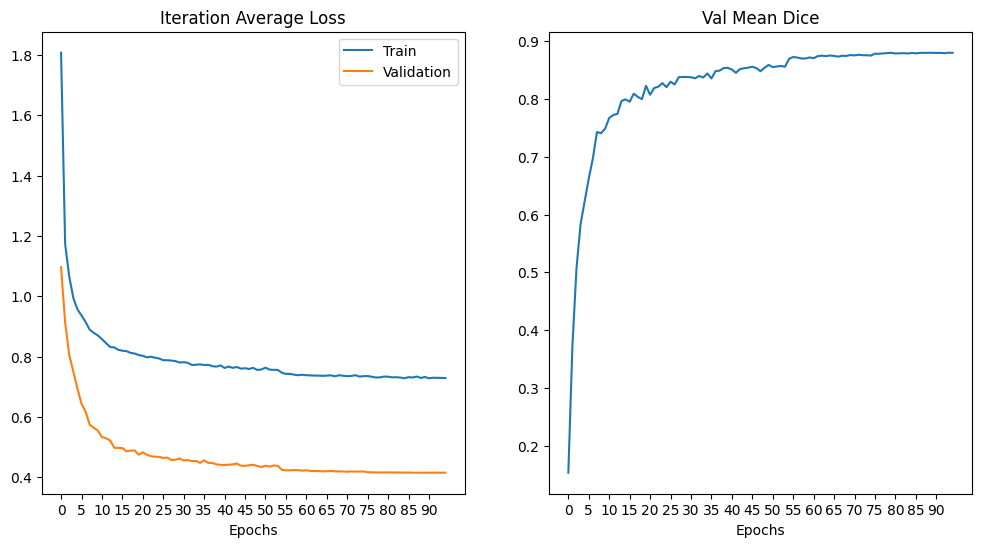

In [10]:
swin_trainer.plot_train_info()

In [11]:
file_list_test = generate_file_path(root_path=f'{root_dataset}/test', label_name=label_name)
test_ds = PersistentDataset(
    data=file_list_test,
    transform=val_transforms,
    cache_dir=f'test_{task_name}'
#     cache_dir='C:/Training/val'
)

test_loader = DataLoader(test_ds, num_workers=0, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [12]:
swin_trainer.test(test_loader)

Test (loss=0.20943): 100%|█████████████████████████████████████████████████████████████| 65/65 [11:40<00:00, 10.78s/it]


([0.9200992748999768,
  0.949615024839197,
  0.9221226538741139,
  0.9250450915147606,
  0.9555596954800085,
  0.9242563342213943,
  0.9446133897641553,
  0.9138603063397513,
  0.897075435961098,
  0.8821303445615939,
  0.9162870301095283,
  0.9139617410749454,
  0.9034680524819797,
  0.8081415454587089,
  0.8878613382319471,
  0.9297684219539495],
 [6.807026608045429,
  2.768798627238937,
  5.0447647326358265,
  9.469515784392394,
  2.8312076633762424,
  9.361229013433023,
  5.907428095554253,
  13.530528778467252,
  9.231600799089062,
  17.19484977696392,
  10.771061619139529,
  4.819129722772724,
  6.072005441993271,
  19.187711196126266,
  14.917280272678019,
  6.180969544189763],
 [0.9817359236883049,
  0.9845014339741611,
  0.9871971278497133,
  0.9688912342446432,
  0.9866338120264354,
  0.9611788061034406,
  0.9676056873825101,
  0.9772208588320845,
  0.960296023658944,
  0.9588119063767874,
  0.9789612643821464,
  0.9824496292112226,
  0.9258974905316737,
  0.9022863954781049,

In [10]:
torch.cuda.empty_cache()

In [11]:
torch.cuda.empty_cache()
swin_trainer.test(test_loader)

Test:   0%|                                                                                     | 0/65 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None
invalid value encountered in double_scalars
torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
Test (loss=0.20943): 100%|█████████████████████████████████████████████████████████████| 65/65 [13:23<00:00, 12.37s/it]


([0.9200992748999768,
  0.8652048004090461,
  0.9221226538741139,
  0.8872881490039538,
  0.9555596954800085,
  0.9242563342213943,
  0.9446133897641553,
  0.8288500452848907,
  0.8580721561367024,
  0.8625274480157807,
  0.8959250961070945,
  0.8733412192493921,
  0.866591805441899,
  0.7919787145495347,
  0.8394325379647501,
  0.9086373214549959],
 [6.807026608045429,
  27.15338129164411,
  5.0447647326358265,
  20.51888239978631,
  2.8312076633762424,
  9.361229013433023,
  5.907428095554253,
  29.506821995474663,
  20.400818939685855,
  21.40497457167043,
  17.200735943474342,
  19.415138258130774,
  18.83961033941341,
  22.109072259964293,
  24.83776594167306,
  15.14401428313526],
 [0.9817359236883049,
  0.8969901953986802,
  0.9871971278497133,
  0.9293446532550662,
  0.9866338120264354,
  0.9611788061034406,
  0.9676056873825101,
  0.886316592894216,
  0.9185440226302944,
  0.93750497512397,
  0.9572065696180987,
  0.9387852012462793,
  0.8881057562242585,
  0.8842406675685427,

In [15]:
for t in train_loader:
    if t['label'].max() == 0:
        print(t['label'].min(), t['label'].max() == 0)
    break